In [3]:
import os
import importlib
import pyhxexpress as hxex
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import random
from sklearn.preprocessing import normalize
import scipy
from keras.models import load_model
#import config  
#import hdxms_params_22Dec2023 as config
import test_config as config
from collections import defaultdict

def hxex_reload():
    importlib.reload(hxex)
    importlib.reload(config)
    hxex.config = config

hxex_reload()
#help(hxex)

#hxex.config.Hide_Figure_Output = False

# hxex.config.Output_DIR = os.path.join(config.Data_DIR,'output_fixedpops_'+str(config.date),'')
# if not os.path.exists(hxex.config.Output_DIR): os.makedirs(hxex.config.Output_DIR)


#metadf = hxex.get_metadf()
#filtered = metadf[0:1]
#filtered = hxex.filter_metadf(metadf,index=[*range(0,2)])#,charge=2, samples='B1B5')
#display(filtered)
#hxex.run_hdx_fits(filtered)
#hxex.run_hdx_fits(metadf)

In [2]:
RandomSeed=2024
random.seed(RandomSeed)
def random_seq(length):
    AA = 'ARNDCQEGHILKMFPSTWYV'
    return "".join(random.choice(AA) for i in range(length))

def get_peptides(num_peptides,cutoff=4):
    peptide_list = {}
    n_in_list = 0
    while n_in_list < num_peptides:
        #peptide_list.append(random_seq(random.randint(5,20)))
        peptide = random_seq(random.randint(5,20))
        namides = hxex.count_amides(peptide)
        if namides >= cutoff:
            peptide_list[peptide] = namides
            n_in_list += 1
    return peptide_list

def random_params(n_curves,max_n_amides,):
    rng=np.random.default_rng()
    log_scaler = 0.0  
    nexs = list(max_n_amides*rng.random(n_curves))

    sampled = rng.random(n_curves*2) #array for both mus and fracs
    mus =  list(sampled[0:n_curves]) 
    fracs = sampled[-n_curves:]
    fracs = list(fracs/np.sum(fracs))

    initial_estimate = [ log_scaler ] + nexs + mus + fracs
    
    return initial_estimate

peptides_list = get_peptides(1000)

In [74]:
#proposed features ['env_width','env_symm','max_namides','TD_env_width']
noise = 0.01 #training on the noise set is a bit crap 

simulated_spectra = pd.DataFrame()
#simulated_spectra = simulated_spectra.asytpe(object)
for peptide,namides in peptides_list.items():
    charge = 1
    hxex.Current_Isotope= hxex.get_na_isotope(peptide,charge,npeaks=None)
    TD_max_spectrum = hxex.n_binom_isotope(namides+5,0.0, namides, 0.999, 1.0) #can't set Nex to exactly 1.0, nCk gives error
    TD_spec = pd.DataFrame(zip(np.arange(len(TD_max_spectrum)),TD_max_spectrum),columns=['mz','Intensity'])
    [left,right] = hxex.get_mz_env(0.1*max(TD_max_spectrum),TD_spec,colname='Intensity')
    TD_env_width = (right - left)*charge

    for npops in [1,1,1,2,3]: #increase single pop training data
        simulated_spectrum = pd.DataFrame()
        charge = 1
        params = random_params(npops,namides)
        
        simulated_spectrum.loc[0,'peptide'] = peptide
        simulated_spectrum.loc[0,'max_namides'] = namides
        simulated_spectrum.loc[0,'charge'] = charge
        simulated_spectrum.loc[0,'npops'] = npops
        string_params = ','.join(str(x) for x in params)
        #string_params.split(',')
        simulated_spectrum.loc[0,'params'] = string_params
        
        spectrum = hxex.n_binom_isotope(namides+5,*params)

        simulated_spectrum.loc[0,'avg_Int'] = spectrum.mean()/spectrum.max()
        #simulated_spectrum.loc[0,'variance'] = np.var(spectrum) #useless info
        simulated_spectrum.loc[0,'kurtosis'] = scipy.stats.kurtosis(spectrum,bias=False)
        simulated_spectrum.loc[0,'skewness'] = scipy.stats.skew(spectrum,bias=False)

        spectrum_with_noise = spectrum + np.random.normal(0., noise, len(spectrum))
        spectrum_with_noise = [max(0,s) for s in spectrum_with_noise]
        spec_df = pd.DataFrame(zip(np.arange(len(spectrum)),spectrum,spectrum_with_noise),columns=['mz','Intensity','Inoisey'])
        [left,right],env_Int = hxex.get_mz_env(0.1*max(spectrum),spec_df,colname='Intensity',pts=True)
        env_width = (right - left)*charge
        env_symm = 2.0 - (max(spectrum) - env_Int)/max(spectrum)
        simulated_spectrum.loc[0,'TD_env_width'] = TD_env_width
        simulated_spectrum.loc[0,'env_width'] = env_width
        simulated_spectrum.loc[0,'env_symm'] = env_symm
        [left,right],env_Int = hxex.get_mz_env(0.1*max(spectrum_with_noise),spec_df,colname='Inoisey',pts=True)
        env_width = (right - left)*charge
        env_symm = 2.0 - (max(spectrum_with_noise) - env_Int)/max(spectrum_with_noise)
        simulated_spectrum.loc[0,'env_width_noise'] = env_width
        simulated_spectrum.loc[0,'env_symm_noise'] = env_symm

        scaler, nexs, mus, fracs = hxex.get_params(*params,sort=True)
        nm = nexs*mus
        separation = []
        separation = np.diff(nm,n=1,axis=-1)
        for ii in range(0,npops-1):
            simulated_spectrum.loc[0,'sep'+str(ii)] = separation[ii]

        simulated_spectra = pd.concat([simulated_spectra,simulated_spectrum],ignore_index = True).reset_index(drop = True)
        # plt.vlines(ymin=np.zeros(len(spectrum)),ymax=spectrum,x=np.arange(len(spectrum)))
        # plt.vlines(ymin=np.zeros(len(spectrum)),ymax=spectrum_with_noise,x=np.arange(len(spectrum)),color='r')
        # plt.show()

In [56]:
simulated_spectra


,peptide,max_namides,charge,npops,params,avg_Int,kurtosis,skewness,TD_env_width,env_width,env_symm,env_width_noise,env_symm_noise,sep0,sep1
0,QYIEFHWGSKFTVEIWLTNE,19.0,1.0,1.0,"0.0,9.08268067502849,0.05635998401117703,1.0",0.151166,3.167412,2.065367,5.487401,5.569195,1.499156,5.747138,1.478593,NaN,NaN
1,QYIEFHWGSKFTVEIWLTNE,19.0,1.0,1.0,"0.0,1.1292746071468223,0.09066979685597731,1.0",0.128473,4.005363,2.240168,5.487401,4.778021,1.645355,5.116679,1.652403,NaN,NaN
2,QYIEFHWGSKFTVEIWLTNE,19.0,1.0,1.0,"0.0,10.090077943118246,0.7693016796862258,1.0",0.183741,1.601693,1.695678,5.487401,8.140615,1.100000,8.361843,1.100000,NaN,NaN
3,QYIEFHWGSKFTVEIWLTNE,19.0,1.0,2.0,"0.0,3.483593793543835,14.002655423162867,0.991...",0.146971,3.288364,2.093577,5.487401,6.674771,1.100000,6.644879,1.100000,0.713111,NaN
4,QYIEFHWGSKFTVEIWLTNE,19.0,1.0,3.0,"0.0,17.305917477738568,17.312467199438615,12.4...",0.417518,-1.538589,0.146831,5.487401,16.691350,1.100000,17.702170,1.100000,2.724440,6.971637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,NKGQD,4.0,1.0,1.0,"0.0,0.9904981186694646,0.1307743063732626,1.0",0.152501,5.993786,2.452244,2.684530,1.979319,2.000000,1.904724,2.000000,NaN,NaN
4996,NKGQD,4.0,1.0,1.0,"0.0,3.6465587811217626,0.46392814152656703,1.0",0.286828,-0.330195,1.081578,2.684530,4.640515,1.222186,4.756255,1.188277,NaN,NaN
4997,NKGQD,4.0,1.0,1.0,"0.0,1.03601460987286,0.3544767423280194,1.0",0.208977,1.443842,1.712977,2.684530,2.648156,2.000000,2.629125,2.000000,NaN,NaN
4998,NKGQD,4.0,1.0,2.0,"0.0,1.7385713361185697,2.2595121721771547,0.58...",0.287688,-0.174599,1.113878,2.684530,4.746814,1.201651,4.852581,1.205504,1.153381,NaN


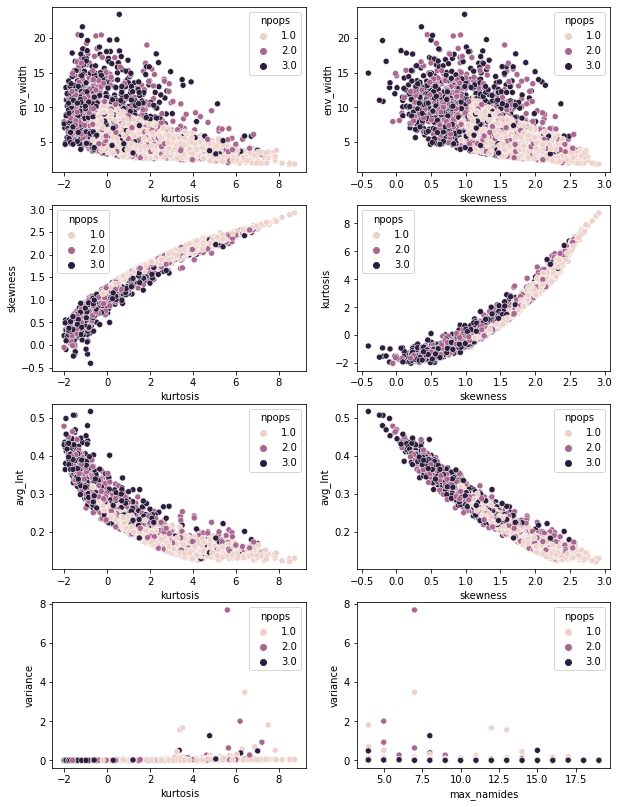

In [77]:
fig,ax=plt.subplots(4,2,figsize=(10,14))
sns.scatterplot(x='kurtosis',y='env_width',hue='npops',data=simulated_spectra,alpha=1.0,ax=ax[0,0])
sns.scatterplot(x='kurtosis',y='skewness',hue='npops',data=simulated_spectra,alpha=1.0,ax=ax[1,0])
sns.scatterplot(x='kurtosis',y='avg_Int',hue='npops',data=simulated_spectra,alpha=1.0,ax=ax[2,0])
sns.scatterplot(x='kurtosis',y='variance',hue='npops',data=simulated_spectra,alpha=1.0,ax=ax[3,0])
sns.scatterplot(x='skewness',y='env_width',hue='npops',data=simulated_spectra,alpha=1.0,ax=ax[0,1])
sns.scatterplot(x='skewness',y='kurtosis',hue='npops',data=simulated_spectra,alpha=1.0,ax=ax[1,1])
sns.scatterplot(x='skewness',y='avg_Int',hue='npops',data=simulated_spectra,alpha=1.0,ax=ax[2,1])
#sns.scatterplot(x='max_namides',y='variance',hue='npops',data=simulated_spectra,alpha=1.0,ax=ax[3,1])
plt.show()

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

tf.keras.utils.set_random_seed(256)

from sklearn.model_selection import train_test_split

#X_features = ['env_width','env_symm','max_namides','TD_env_width','skewness'] #still not better
#X_features = ['env_width','env_symm','skewness','TD_env_width'] #not better
X_features = ['env_width','env_symm','max_namides','TD_env_width'] #"model4"
#X_features = ['env_width_noise','env_symm_noise','max_namides'] #performing very poorly

data = simulated_spectra.copy()
X = data[X_features].to_numpy()
y = data[['npops']].to_numpy().ravel() - 1 #-1 to be 0,1,2 

# ybinary = [min(yy,1.0) for yy in y]
# ybinary = np.asarray(ybinary).astype('float32')

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# normalization_layer = tf.keras.layers.experimental.preprocessing.Normalization()
# normalization_layer.adapt(X)

X_train, X_val, y_train, y_val = train_test_split(X,y,stratify=y,test_size=0.15)
#Xb_train, Xb_val, yb_train, yb_val = train_test_split(X,ybinary,stratify=y,test_size=0.15)

#y = [1 if yt > 1 else 0 for yt in y_train]
#y = np.array(y)


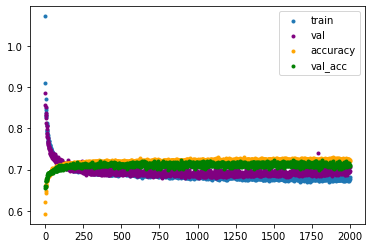

In [103]:
class GetWeights(tf.keras.callbacks.Callback):
    # Keras callback which collects values of weights and biases at each epoch
    def __init__(self):
        super(GetWeights, self).__init__()
        self.weight_dict = {}

    def on_epoch_end(self, epoch, logs=None):
        # this function runs at the end of each epoch

        # loop over each layer and get weights and biases
        for layer_i in range(len(self.model.layers)):
            if self.model.layers[layer_i].__class__.__name__ == "Dropout":
                continue
            w = self.model.layers[layer_i].get_weights()[0]
            b = self.model.layers[layer_i].get_weights()[1]
            #print('Layer %s has weights of shape %s and biases of shape %s' %(
            #    layer_i, np.shape(w), np.shape(b)))

            # save all weights and biases inside a dictionary
            if epoch == 0:
                # create array to hold weights and biases
                self.weight_dict['w_'+str(layer_i+1)] = w
                self.weight_dict['b_'+str(layer_i+1)] = b
            else:
                # append new weights to previously-created weights array
                self.weight_dict['w_'+str(layer_i+1)] = np.dstack(
                    (self.weight_dict['w_'+str(layer_i+1)], w))
                # append new weights to previously-created weights array
                self.weight_dict['b_'+str(layer_i+1)] = np.dstack(
                    (self.weight_dict['b_'+str(layer_i+1)], b))

dense_model = Sequential(
    [ 
        Dense(25, activation = 'relu'), #25,15
        Dropout(0.1),
        Dense(15, activation = 'relu'),
        Dense(3, activation = 'linear')   
    ]
)

preferred_model = dense_model ##

preferred_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999),
    metrics=['accuracy']
)

gw = GetWeights()
history = preferred_model.fit(
    X_train,y_train, verbose=0,callbacks=[gw],
    validation_data=(X_val,y_val),
    epochs=2000
)

#Plot Training Performance
plt.scatter(np.arange(0,len(history.history['loss'])),history.history['loss'],label='train',marker='.');
plt.scatter(np.arange(0,len(history.history['val_loss'])),history.history['val_loss'],color='purple',label='val',marker='.');
plt.scatter(np.arange(0,len(history.history['accuracy'])),history.history['accuracy'],label='accuracy',marker='.',color='orange');
plt.scatter(np.arange(0,len(history.history['val_accuracy'])),history.history['val_accuracy'],color='green',label='val_acc',marker='.');
plt.legend()

  1/133 [..............................] - ETA: 3s

18/18 [==============================] - 0s 939us/step


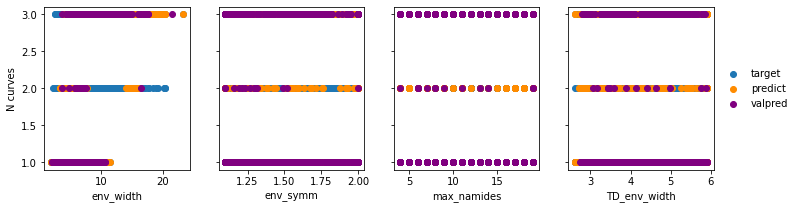

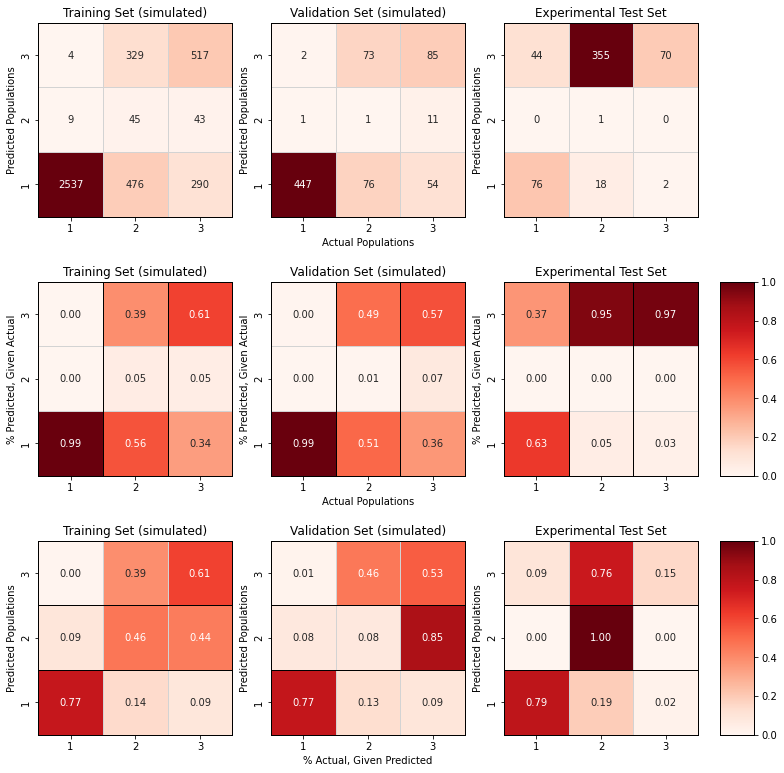

In [139]:

train_pred = preferred_model.predict(X_train)
val_pred = preferred_model.predict(X_val)
y_trainpred = np.argmax(train_pred,axis=1)
y_valpred = np.argmax(val_pred,axis=1)

X_pred = preferred_model.predict(X)
#sm_preferred = tf.nn.softmax(test_pred).numpy()
y_pred = np.argmax(X_pred,axis=1)
simulated_spectra['npop_pred'] = y_pred+1
simulated_spectra['correct'] = np.where((simulated_spectra['npops']==simulated_spectra['npop_pred']),True,False)

# plot predictions and targets vs original features    
fig,ax=plt.subplots(1,len(X_features),figsize=(12,3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train+1, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter(X_train[:,i],y_trainpred+1,color="darkorange", label = 'predict')
    ax[i].scatter(X_val[:,i],y_valpred+1,color="purple", label = 'valpred',marker='o')
ax[0].set_ylabel("N curves"); 
ax[len(X_features)-1].legend(loc='center left',bbox_to_anchor=(1,0.5),frameon=False);
#fig.suptitle("target versus prediction")

#Get test data and calculate features 
testfile = os.path.join(hxex.config.Data_DIR,'output_23Jan2024','data_fits23Jan2024.csv')
test_data = pd.read_csv(testfile).drop('Index',axis=1)

test_peptides = test_data['peptide'].unique()
for tpeptide in test_peptides:
    namides = hxex.count_amides(tpeptide)
    hxex.Current_Isotope= hxex.get_na_isotope(tpeptide,charge=1)
    TD_max_spectrum = hxex.n_binom_isotope(namides+5,0.0, namides, 0.999, 1.0) #can't set Nex to exactly 1.0, nCk gives error
    TD_spec = pd.DataFrame(zip(np.arange(len(TD_max_spectrum)),TD_max_spectrum),columns=['mz','Intensity'])
    [left,right] = hxex.get_mz_env(0.1*max(TD_max_spectrum),TD_spec,colname='Intensity')
    TD_env_width = (right - left)*charge
    test_data.loc[test_data['peptide'] == tpeptide,['TD_env_width']] = TD_env_width
X_test = test_data[X_features].to_numpy().astype('float32')
y_test = test_data['solution_npops'].to_numpy().astype('float32').ravel()-1
test_pred = preferred_model.predict(X_test)
y_testpred = np.argmax(test_pred,axis=1)
test_data['npops_pred'] = y_testpred+1

#Plot Prediction vs Actual heatmaps
heatmaps = defaultdict(dict)
offset = 1
heatmap, xedges, yedges = np.histogram2d(y_trainpred+offset,y_train+offset,bins=3)
heatmaps['Training Set (simulated)']['heatmap'] = heatmap
heatmaps['Training Set (simulated)']['Given Measured'] = normalize(heatmap,axis=0,norm='l1')
heatmaps['Training Set (simulated)']['Given Predicted'] = normalize(heatmap,axis=1,norm='l1')
heatmap, xedges, yedges = np.histogram2d(y_valpred+offset,y_val+offset,bins=3)
heatmaps['Validation Set (simulated)']['heatmap'] = heatmap
heatmaps['Validation Set (simulated)']['Given Measured'] = normalize(heatmap,axis=0,norm='l1')
heatmaps['Validation Set (simulated)']['Given Predicted'] = normalize(heatmap,axis=1,norm='l1')
heatmap, xedges, yedges = np.histogram2d(y_testpred+offset,y_test+offset,bins=3)
heatmaps['Experimental Test Set']['heatmap'] = heatmap
heatmaps['Experimental Test Set']['Given Measured'] = normalize(heatmap,axis=0,norm='l1')
heatmaps['Experimental Test Set']['Given Predicted'] = normalize(heatmap,axis=1,norm='l1')
data_type_keys = heatmaps.keys()
norm_keys = ['heatmap','Given Measured','Given Predicted']
labels = ['1','2','3']

#fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5,5),gridspec_kw={'width_ratios':[10,1]})
nrows = len(norm_keys)
ncols = len(data_type_keys)+1
vmin = 0
fig2,ax2=plt.subplots(nrows=len(norm_keys),ncols=ncols,figsize=(ncols*4,nrows*4.5),sharey=False,)#constrained_layout=True)
for i,d in enumerate(data_type_keys):
    for j,n in enumerate(norm_keys):
        if n == 'heatmap': 
            txt_format = '.0f'
            vmin = 0
            vmax = None
            cbar = False
        else: 
            txt_format = '.2f'
            vmin=0
            vmax = 1
            cbar = True
        sns.heatmap(heatmaps[d][n],annot=True,fmt=txt_format,cbar=cbar,cmap='Reds',xticklabels=labels,yticklabels=labels,
                    vmin=vmin,vmax=vmax,linewidths=1.0,ax=ax2[j,i],cbar_ax=ax2[j,3],linecolor='lightgrey')
        ax2[j,i].invert_yaxis()
        ax2[j,i].set_box_aspect(1)
        for ii in range(len(ax2[j])):
            for spine in ax2[j][ii].spines.values():
                spine.set(visible=True, lw=1.0, edgecolor="black")
        ax2[-2,i].vlines(ymin=(0,0),ymax=(3,3),x=(1,2),color='k',linewidth=1)
        ax2[-1,i].hlines(xmin=(0,0),xmax=(3,3),y=(1,2),color='k',linewidth=1)
        ax2[j,-1].set_position([ax2[j,-1].get_position().x0-.005,ax2[j,-2].get_position().y0,0.03,ax2[j,-2].get_position().y1-ax2[j,-2].get_position().y0])
        ax2[j,1].set_xlabel("Actual Populations")
        ax2[j,i].set_ylabel("Predicted Populations")
        ax2[-2,i].set_ylabel("% Predicted, Given Actual")
        ax2[j,i].set_title(d)
fig2.delaxes(ax2[0][-1])

ax2[-1,1].set_xlabel("% Actual, Given Predicted") 
plt.show()

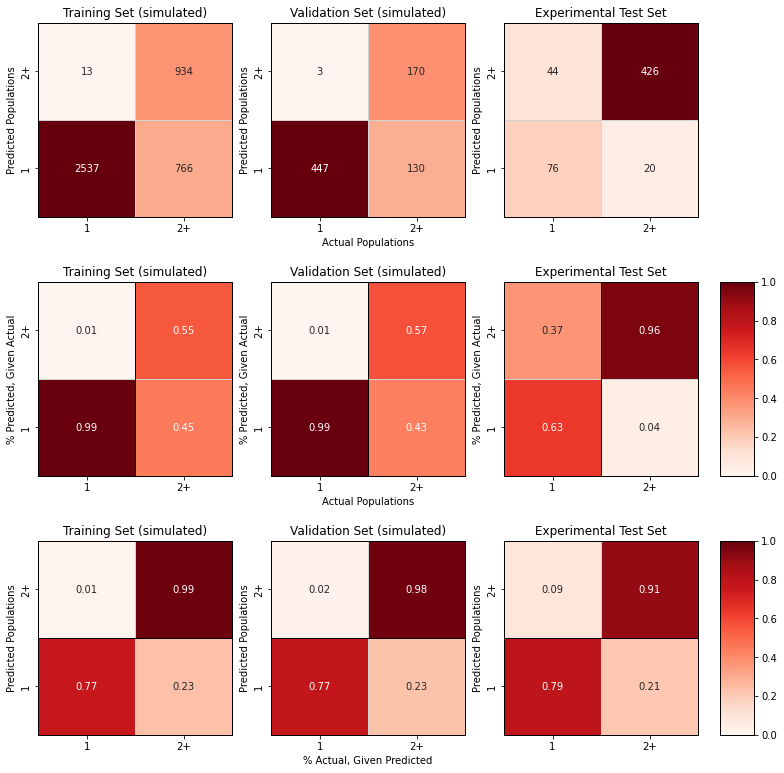

In [158]:
#heatmap, xedges, yedges = np.histogram2d(y_trainpred+offset,y_train+offset,bins=3)
heatbinary = defaultdict(dict)

y_trainpredb = np.array([min(i,1) for i in y_trainpred])
y_trainb = np.array([min(i,1) for i in y_train])
y_valpredb = np.array([min(i,1) for i in y_valpred])
y_valb = np.array([min(i,1) for i in y_val])
y_testpredb = np.array([min(i,1) for i in y_testpred])
y_testb = np.array([min(i,1) for i in y_test])

heatb,xedgeb,yedgesb = np.histogram2d(y_trainpredb +offset,y_trainb+offset,bins=2)
heatbinary['Training Set (simulated)']['heatmap'] = heatb
heatbinary['Training Set (simulated)']['Given Measured'] = normalize(heatb,axis=0,norm='l1')
heatbinary['Training Set (simulated)']['Given Predicted'] = normalize(heatb,axis=1,norm='l1')
heatb, xedgesb, yedgesb = np.histogram2d(y_valpredb+offset,y_valb+offset,bins=2)
heatbinary['Validation Set (simulated)']['heatmap'] = heatb
heatbinary['Validation Set (simulated)']['Given Measured'] = normalize(heatb,axis=0,norm='l1')
heatbinary['Validation Set (simulated)']['Given Predicted'] = normalize(heatb,axis=1,norm='l1')
heatb, xedgesb, yedgesb = np.histogram2d(y_testpredb+offset,y_testb+offset,bins=2)
heatbinary['Experimental Test Set']['heatmap'] = heatb
heatbinary['Experimental Test Set']['Given Measured'] = normalize(heatb,axis=0,norm='l1')
heatbinary['Experimental Test Set']['Given Predicted'] = normalize(heatb,axis=1,norm='l1')
data_type_keys = heatbinary.keys()
norm_keys = ['heatmap','Given Measured','Given Predicted']
labels = ['1','2+']

#fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5,5),gridspec_kw={'width_ratios':[10,1]})
nrows = len(norm_keys)
ncols = len(data_type_keys)+1
vmin = 0
fig2,ax2=plt.subplots(nrows=nrows,ncols=ncols,figsize=(ncols*4,nrows*4.5),sharey=False,)#constrained_layout=True)
for i,d in enumerate(data_type_keys):
    for j,n in enumerate(norm_keys):
        if n == 'heatmap': 
            txt_format = '.0f'
            vmin = 0
            vmax = None
            cbar = False
        else: 
            txt_format = '.2f'
            vmin=0
            vmax = 1
            cbar = True
        sns.heatmap(heatbinary[d][n],annot=True,fmt=txt_format,cbar=cbar,cmap='Reds',xticklabels=labels,yticklabels=labels,
                    vmin=vmin,vmax=vmax,linewidths=1.0,ax=ax2[j,i],cbar_ax=ax2[j,3],linecolor='lightgrey')
        ax2[j,i].invert_yaxis()
        ax2[j,i].set_box_aspect(1)
        for ii in range(len(ax2[j])):
            for spine in ax2[j][ii].spines.values():
                spine.set(visible=True, lw=1.0, edgecolor="black")
        ax2[-2,i].vlines(ymin=(0,0),ymax=(3,3),x=(1,2),color='k',linewidth=1)
        ax2[-1,i].hlines(xmin=(0,0),xmax=(3,3),y=(1,2),color='k',linewidth=1)
        ax2[j,-1].set_position([ax2[j,-1].get_position().x0-.005,ax2[j,-2].get_position().y0,0.03,ax2[j,-2].get_position().y1-ax2[j,-2].get_position().y0])
        ax2[j,1].set_xlabel("Actual Populations")
        ax2[j,i].set_ylabel("Predicted Populations")
        ax2[-2,i].set_ylabel("% Predicted, Given Actual")
        ax2[j,i].set_title(d)
fig2.delaxes(ax2[0][-1])

ax2[-1,1].set_xlabel("% Actual, Given Predicted") 
plt.show()

In [140]:
# save the model for future use
#preferred_model.save(os.path.join(hxex.config.Data_DIR,'model4_1000peps_4feat_23jan24.keras'))
fig2.savefig(os.path.join(config.Data_DIR,'npops_actual_vs_predicted_model4binary_23jan2024.pdf'),format='pdf',dpi=600)
fig2.savefig(os.path.join(config.Data_DIR,'npops_actual_vs_predicted_model4binary_23jan2024.svg'),format='svg')

In [9]:
sm_train = tf.nn.softmax(train_pred).numpy()
sm_val = tf.nn.softmax(val_pred).numpy()
sm_test = tf.nn.softmax(test_pred).numpy()

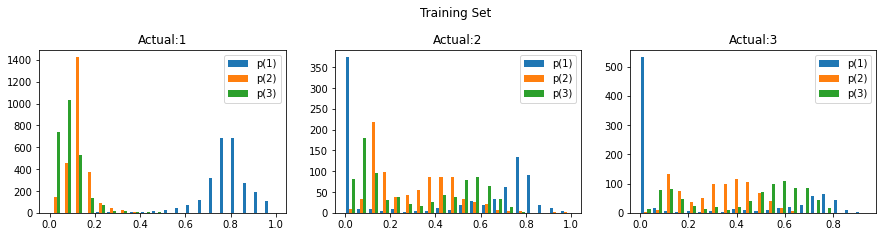

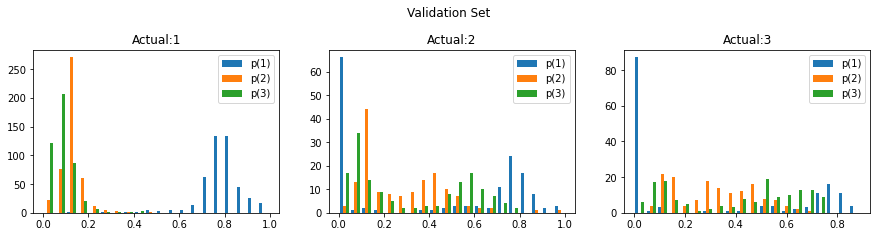

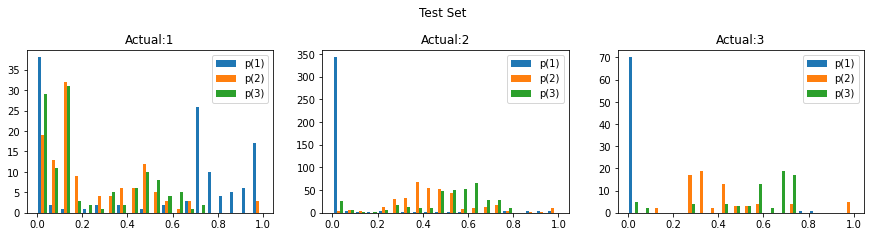

In [10]:
from matplotlib.ticker import PercentFormatter

sm_train_1 = sm_train[y_train == 0]
sm_train_2 = sm_train[y_train == 1]
sm_train_3 = sm_train[y_train == 2]
fig,ax=plt.subplots(1,3,figsize=(15,3))
ax[0].hist(sm_train_1,bins=20,label=['p(1)','p(2)','p(3)'],density=False)
ax[1].hist(sm_train_2,bins=20,label=['p(1)','p(2)','p(3)'],density=False)
ax[2].hist(sm_train_3,bins=20,label=['p(1)','p(2)','p(3)'],density=False)
for axi in range(len(ax)): 
    ax[axi].legend()
    ax[axi].set_title("Actual:"+str(axi+1));
fig.suptitle("Training Set",x=0.51,y=1.08)
plt.show()
sm_val_1 = sm_val[y_val == 0]
sm_val_2 = sm_val[y_val == 1]
sm_val_3 = sm_val[y_val == 2]
fig,ax=plt.subplots(1,3,figsize=(15,3))
ax[0].hist(sm_val_1,bins=20,label=['p(1)','p(2)','p(3)'],density=False)
ax[1].hist(sm_val_2,bins=20,label=['p(1)','p(2)','p(3)'],density=False)
ax[2].hist(sm_val_3,bins=20,label=['p(1)','p(2)','p(3)'],density=False)
for axi in range(len(ax)): 
    ax[axi].legend()
    ax[axi].set_title("Actual:"+str(axi+1));
fig.suptitle("Validation Set",x=0.51,y=1.08)
plt.show()
sm_test_1 = sm_test[y_test == 0]
sm_test_2 = sm_test[y_test == 1]
sm_test_3 = sm_test[y_test == 2]
fig,ax=plt.subplots(1,3,figsize=(15,3))
ax[0].hist(sm_test_1,bins=20,label=['p(1)','p(2)','p(3)'],density=False)
ax[1].hist(sm_test_2,bins=20,label=['p(1)','p(2)','p(3)'],density=False)
ax[2].hist(sm_test_3,bins=20,label=['p(1)','p(2)','p(3)'],density=False)
for axi in range(len(ax)): 
    ax[axi].legend()
    ax[axi].set_title("Actual:"+str(axi+1));
fig.suptitle("Test Set",x=0.51,y=1.08)
plt.show()

In [11]:
X_pred = preferred_model.predict(X)
#sm_preferred = tf.nn.softmax(test_pred).numpy()
y_pred = np.argmax(X_pred,axis=1)
simulated_spectra['npop_pred'] = y_pred+1
simulated_spectra['correct'] = np.where((simulated_spectra['npops']==simulated_spectra['npop_pred']),True,False)

157/157 [==============================] - 0s 820us/step


In [534]:
simulated_spectra

,peptide,max_namides,charge,npops,params,TD_env_width,env_width,env_symm,env_width_noise,env_symm_noise,sep0,sep1,npop_pred,correct
0,QYIEFHWGSKFTVEIWLTNE,19.0,1.0,1.0,"0.0,1.009261649954462,0.8149999487960873,1.0",5.487401,5.572990,1.132056,6.070068,1.124860,NaN,NaN,1,True
1,QYIEFHWGSKFTVEIWLTNE,19.0,1.0,1.0,"0.0,16.845574848184814,0.7263952966185219,1.0",5.487401,9.681753,1.100000,13.331584,1.100000,NaN,NaN,1,True
2,QYIEFHWGSKFTVEIWLTNE,19.0,1.0,1.0,"0.0,18.928709066304055,0.7661736675159901,1.0",5.487401,9.717312,1.100000,13.605909,1.100000,NaN,NaN,1,True
3,QYIEFHWGSKFTVEIWLTNE,19.0,1.0,2.0,"0.0,5.951064675082897,2.360688763428841,0.0346...",5.487401,4.985218,1.581317,4.859919,1.548633,0.079654,NaN,1,False
4,QYIEFHWGSKFTVEIWLTNE,19.0,1.0,3.0,"0.0,5.312379913528916,4.070135610086015,11.533...",5.487401,14.084484,1.100000,20.182299,1.100000,0.548306,6.895795,3,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,NKGQD,4.0,1.0,1.0,"0.0,1.0625245587854075,0.06787287787025575,1.0",2.684530,1.904949,2.000000,1.897187,2.000000,NaN,NaN,1,True
4996,NKGQD,4.0,1.0,1.0,"0.0,2.3674125598727973,0.3754059657106107,1.0",2.684530,3.501456,1.592854,3.433466,1.551158,NaN,NaN,1,True
4997,NKGQD,4.0,1.0,1.0,"0.0,2.8736022548816256,0.28817747779198677,1.0",2.684530,3.505586,1.700668,3.832129,1.747388,NaN,NaN,1,True
4998,NKGQD,4.0,1.0,2.0,"0.0,1.1465313568833664,3.693555495554031,0.547...",2.684530,5.477170,1.594115,5.641559,1.587781,2.502500,NaN,3,False


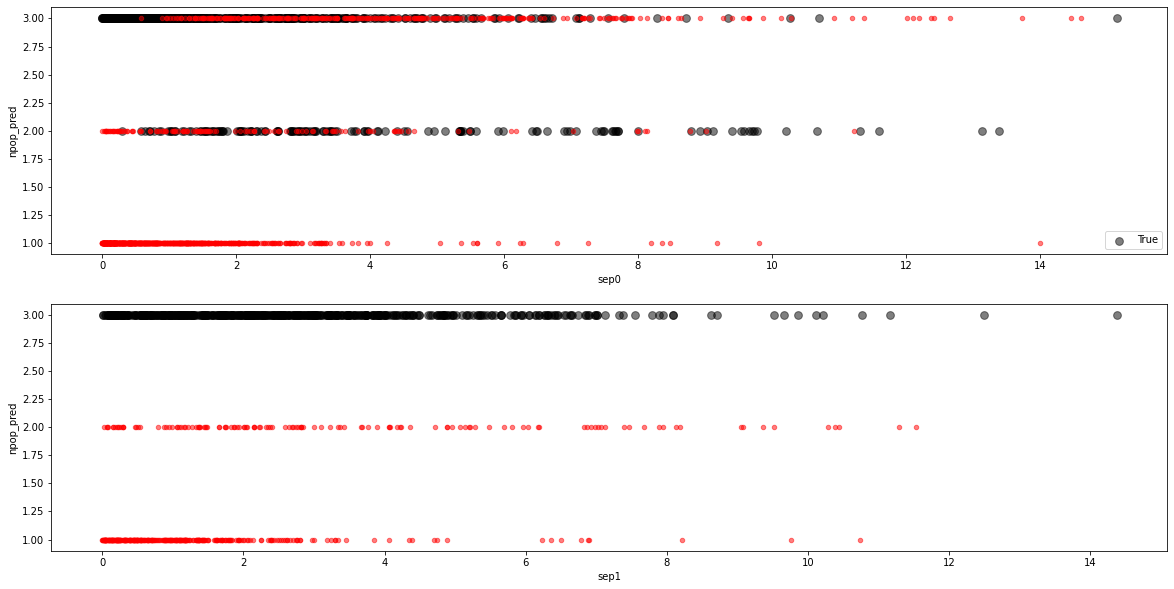

In [535]:
fig,ax=plt.subplots(nrows=2,ncols=1,figsize=(20,10))
truedf = simulated_spectra[simulated_spectra['correct']==True]
wrongdf = simulated_spectra[simulated_spectra['correct']==False]
truedf.plot.scatter(x='sep0',y='npop_pred',legend=True,ax=ax[0],color='black',label='True',s=60,alpha=0.5)
wrongdf.plot.scatter(x='sep0',y='npop_pred',legend=True,ax=ax[0],color='red',s=20,alpha=0.5)
truedf.plot.scatter(x='sep1',y='npop_pred',legend=True,ax=ax[1],color='black',s=60,alpha=0.5)
wrongdf.plot.scatter(x='sep1',y='npop_pred',legend=True,ax=ax[1],color='red',s=20,alpha=0.5);

#simulated_spectra.plot.scatter('sep1','npops')

In [304]:
truedf

,peptide,max_namides,charge,npops,params,TD_env_width,env_width,env_symm,env_width_noise,env_symm_noise,sep0,sep1,npop_pred,correct
0,QYIEFHWGSKFTVEIWLTNE,19.0,1.0,1.0,"0.0,1.009261649954462,0.8149999487960873,1.0",5.487401,5.572990,1.132056,6.070068,1.124860,NaN,NaN,1,True
1,QYIEFHWGSKFTVEIWLTNE,19.0,1.0,1.0,"0.0,16.845574848184814,0.7263952966185219,1.0",5.487401,9.681753,1.100000,13.331584,1.100000,NaN,NaN,1,True
2,QYIEFHWGSKFTVEIWLTNE,19.0,1.0,1.0,"0.0,18.928709066304055,0.7661736675159901,1.0",5.487401,9.717312,1.100000,13.605909,1.100000,NaN,NaN,1,True
4,QYIEFHWGSKFTVEIWLTNE,19.0,1.0,3.0,"0.0,5.312379913528916,4.070135610086015,11.533...",5.487401,14.084484,1.100000,20.182299,1.100000,0.548306,6.895795,3,True
5,CWEFRKFPDCLMLKELFFL,17.0,1.0,1.0,"0.0,14.4630573751389,0.49724008074515036,1.0",5.873087,10.318757,1.100000,10.871935,1.100000,NaN,NaN,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4991,GFNDGASSYA,9.0,1.0,1.0,"0.0,3.281560679682093,0.6608846333950888,1.0",3.400860,5.352410,1.100000,5.568465,1.100000,NaN,NaN,1,True
4992,GFNDGASSYA,9.0,1.0,1.0,"0.0,1.649012108862959,0.737951781058794,1.0",3.400860,4.284482,1.148014,4.102298,1.141094,NaN,NaN,1,True
4995,NKGQD,4.0,1.0,1.0,"0.0,1.0625245587854075,0.06787287787025575,1.0",2.684530,1.904949,2.000000,1.897187,2.000000,NaN,NaN,1,True
4996,NKGQD,4.0,1.0,1.0,"0.0,2.3674125598727973,0.3754059657106107,1.0",2.684530,3.501456,1.592854,3.433466,1.551158,NaN,NaN,1,True


In [539]:
test_data

,time,rep,centroid,sample,peptide,peptide_range,charge,env_width,env_symm,max_namides,...,icentroid_3,iD_corr3,ipop_3,ipop_std_3,imu_3,iNex_3,iNex_std_3,solution_npops,TD_env_width,npops_pred
0,0,1,556.576154,LeuEnk_HI,YGGFL,0001-0005,1,1.773513,2.000000,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.774605,1
1,60,1,557.541682,LeuEnk_HI,YGGFL,0001-0005,1,3.731877,1.667691,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.774605,1
2,120,1,558.415242,LeuEnk_HI,YGGFL,0001-0005,1,4.744240,1.156377,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.774605,1
3,180,1,559.318773,LeuEnk_HI,YGGFL,0001-0005,1,5.008303,1.100000,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.774605,1
4,240,1,558.186090,LeuEnk_HI,YGGFL,0001-0005,1,5.397880,2.000000,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.774605,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,19,1,643.094765,pep42_LO,RDKVQKEYALFYKLD,0001-0015,3,10.632609,1.100000,14,...,641.470963,6.113526,0.208744,1.0,0.862111,6.000000,1.569593e+08,2,4.754315,3
562,20,1,641.259406,pep42_LO,RDKVQKEYALFYKLD,0001-0015,3,16.164550,1.747186,14,...,642.732614,10.566175,0.381553,1.0,0.425777,20.983282,7.532734e+07,3,4.754315,3
563,21,1,641.691564,pep42_LO,RDKVQKEYALFYKLD,0001-0015,3,17.018653,1.764202,14,...,643.724030,14.065104,0.279575,1.0,0.909535,13.060313,4.760520e+03,3,4.754315,3
564,22,1,642.450123,pep42_LO,RDKVQKEYALFYKLD,0001-0015,3,15.663056,1.100000,14,...,643.698075,13.973503,0.443656,1.0,0.913801,12.898341,2.882567e+01,3,4.754315,3


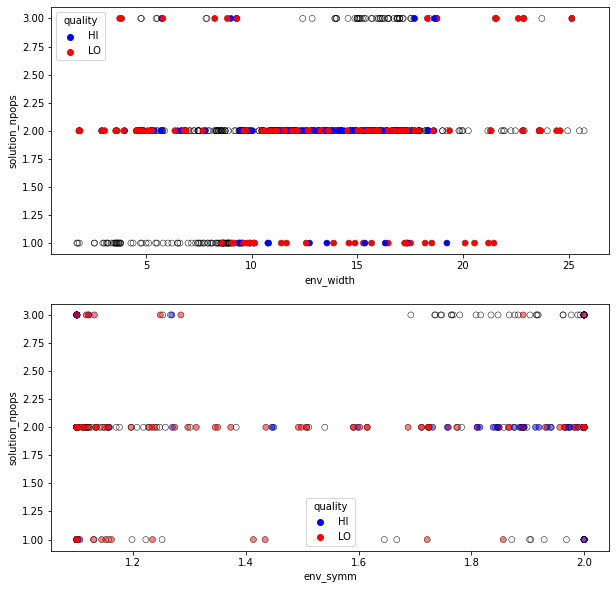

In [12]:
#Low quality data is more likely to have incorrect spectral envelope leading to over estimation of npops
test_data['correct'] = np.where((test_data['solution_npops']==test_data['npops_pred']),True,False)
test_data['quality'] = np.where((test_data['sample'].str.contains('HI')),'HI','LO')
test_data_wrong = test_data[test_data['correct']==False]
fig,ax=plt.subplots(2,1,figsize=(10,10))
sns.scatterplot(x='env_width',y='solution_npops',data=test_data,alpha=1.0,ax=ax[0],color='none',ec="black")
sns.scatterplot(x='env_width',y='solution_npops',hue='quality',data=test_data_wrong,alpha=1.0,ax=ax[0],palette=['b','r'],ec="none");
#ax[0].title("Wrong predicted npops data")

sns.scatterplot(x='env_symm',y='solution_npops',alpha=1.0,data=test_data,ax=ax[1],color='none',ec="black")
sns.scatterplot(x='env_symm',y='solution_npops',hue='quality',data=test_data_wrong,alpha=0.5,ax=ax[1],palette=['b','r'],ec="none");


In [4]:
#from  keras.models import load_model
model = load_model(os.path.join(hxex.config.Data_DIR,'model_1000peps_nonoise_22jan24.keras'))
#X_loadpred = model.predict(X)
#sm_preferred = tf.nn.softmax(test_pred).numpy()
#y_loadpred = np.argmax(X_loadpred,axis=1)
#plt.scatter(y_pred,y_loadpred,alpha=0.01)

In [23]:
def get_TDenv(datafits):
   df = datafits.copy()
   test_set = df[['peptide','max_namides']].drop_duplicates()
   test_peptides = dict(zip(test_set['peptide'],test_set['max_namides'])) 
   for peptide,namides in test_peptides.items():
      charge = 1
      hxex.Current_Isotope= hxex.get_na_isotope(peptide,charge,npeaks=None)
      TD_max_spectrum = hxex.n_binom_isotope(namides+5,0.0, namides, 0.999, 1.0) #can't set Nex to exactly 1.0, nCk gives error
      TD_spec = pd.DataFrame(zip(np.arange(len(TD_max_spectrum)),TD_max_spectrum),columns=['mz','Intensity'])
      [left,right] = hxex.get_mz_env(0.1*max(TD_max_spectrum),TD_spec,colname='Intensity')
      TD_env_width = (right - left)*charge
      peptide_idx = df[(df['peptide'] == peptide)].index
      df.loc[peptide_idx,'TD_env_width'] = TD_env_width
   return df

def predict_pops(trained_model,datafits):
   df = datafits.copy()
   if 'TD_env_width' not in df.columns:
      df = get_TDenv(df)
   X_features = ['env_width','env_symm','max_namides','TD_env_width'] #"model4"
   Xtest = df[X_features].to_numpy()
   Xtest_pred = model.predict(Xtest)
   ytest_pred = np.argmax(Xtest_pred,axis=1)
   ytest_pred_binary = np.array([min(y,1) for y in ytest_pred])+1
   df['pred_pops'] = ytest_pred_binary
   return df 

#test_fits = pd.read_csv("C:\\Users\\tuttl\\OneDrive\\Documents\\My Documents\\KlevitHahn\\hdx-ms\\pyHXExpress\\Bimodal_HDX_Data\\output_26Jan2024\\data_fits26Jan2024.csv")

test_fit_mod = get_TDenv(test_fits)

X_features = ['env_width','env_symm','max_namides','TD_env_width'] #"model4"
Xtest = test_fit_mod[X_features].to_numpy()

Xtest_pred = model.predict(Xtest)
ytest_pred = np.argmax(Xtest_pred,axis=1)
ytest_pred_binary = np.array([min(y,1) for y in ytest_pred])+1

test_fit_mod['pred_pops'] = ytest_pred_binary

In [39]:
test_fit_mod

,Index,time,rep,centroid,sample,peptide,peptide_range,charge,env_width,env_symm,...,iD_corr3,ipop_3,ipop_std_3,imu_3,iNex_3,iNex_std_3,solution_npops,skewness,TD_env_width,pred_pops
0,0,0,1,556.576154,LeuEnk_HI,YGGFL,0001-0005,1,1.773513,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,1,3.078513,2.774605,1
1,1,60,1,557.541682,LeuEnk_HI,YGGFL,0001-0005,1,3.731877,1.667691,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1.416363,2.774605,1
2,2,120,1,558.415242,LeuEnk_HI,YGGFL,0001-0005,1,4.744240,1.156377,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1.465957,2.774605,1
3,3,180,1,559.318773,LeuEnk_HI,YGGFL,0001-0005,1,5.008303,1.100000,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1.411916,2.774605,1
4,4,240,1,558.186090,LeuEnk_HI,YGGFL,0001-0005,1,5.397880,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,2,1.639021,2.774605,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,561,19,1,643.094765,pep42_LO,RDKVQKEYALFYKLD,0001-0015,3,10.632609,1.100000,...,6.118891,0.208744,1.0,0.862111,6.000000,1.569593e+08,2,1.617865,4.754315,2
562,562,20,1,641.259406,pep42_LO,RDKVQKEYALFYKLD,0001-0015,3,16.164550,1.747186,...,10.568511,0.381553,1.0,0.425777,20.983282,7.532734e+07,3,1.164329,4.754315,2
563,563,21,1,641.691564,pep42_LO,RDKVQKEYALFYKLD,0001-0015,3,17.018653,1.764202,...,14.065060,0.279575,1.0,0.909535,13.060313,4.760520e+03,3,0.984412,4.754315,2
564,564,22,1,642.450123,pep42_LO,RDKVQKEYALFYKLD,0001-0015,3,15.663056,1.100000,...,13.973521,0.443656,1.0,0.913801,12.898341,2.882567e+01,3,1.136604,4.754315,2


In [45]:
temp_idx = test_fit_mod[(test_fit_mod['solution_npops']>1) & (test_fit_mod['pred_pops']>1)].index
test_fit_mod.loc[temp_idx,'hit or miss'] = 1
temp_idx = test_fit_mod[(test_fit_mod['solution_npops']>1) & (test_fit_mod['pred_pops']<2)].index
test_fit_mod.loc[temp_idx,'hit or miss'] = 0
temp_idx = test_fit_mod[(test_fit_mod['solution_npops']==1) & (test_fit_mod['pred_pops']>1)].index
test_fit_mod.loc[temp_idx,'hit or miss'] = 0
temp_idx = test_fit_mod[(test_fit_mod['solution_npops']==1) & (test_fit_mod['pred_pops']==1)].index
test_fit_mod.loc[temp_idx,'hit or miss'] = 1


In [47]:
misses = test_fit_mod[test_fit_mod['hit or miss']==0]

In [53]:
misses[misses['pred_pops']==1] #21, bradykinin, LeuEnk YGGFL, pep42 1080s (also not fit correctly)
#misses[misses['pred_pops']==2]

,Index,time,rep,centroid,sample,peptide,peptide_range,charge,env_width,env_symm,...,ipop_3,ipop_std_3,imu_3,iNex_3,iNex_std_3,solution_npops,skewness,TD_env_width,pred_pops,hit or miss
5,5,300,1,557.018739,LeuEnk_HI,YGGFL,0001-0005,1,2.901720,2.000000,...,NaN,NaN,NaN,NaN,NaN,2,2.202193,2.774605,1,0.0
12,12,720,1,558.930412,LeuEnk_HI,YGGFL,0001-0005,1,5.328603,1.100000,...,NaN,NaN,NaN,NaN,NaN,2,1.259880,2.774605,1,0.0
13,13,780,1,559.642811,LeuEnk_HI,YGGFL,0001-0005,1,4.774501,1.100000,...,NaN,NaN,NaN,NaN,NaN,2,1.553134,2.774605,1,0.0
15,15,900,1,558.265618,LeuEnk_HI,YGGFL,0001-0005,1,4.706211,1.269505,...,NaN,NaN,NaN,NaN,NaN,2,1.330663,2.774605,1,0.0
18,18,1080,1,559.537945,LeuEnk_HI,YGGFL,0001-0005,1,4.915153,1.100000,...,NaN,NaN,NaN,NaN,NaN,2,1.492339,2.774605,1,0.0
28,28,5,1,557.213925,LeuEnk_LO,YGGFL,0001-0005,1,2.923228,2.000000,...,0.136520,1.0,0.933270,3.980864,5.465475e+09,2,2.204605,2.774605,1,0.0
36,36,13,1,559.005296,LeuEnk_LO,YGGFL,0001-0005,1,5.288720,1.100000,...,0.136520,1.0,0.933270,3.980864,5.465475e+09,2,1.262621,2.774605,1,0.0
37,37,14,1,559.683766,LeuEnk_LO,YGGFL,0001-0005,1,5.085052,1.100000,...,0.136520,1.0,0.933270,3.980864,5.465475e+09,2,1.483839,2.774605,1,0.0
39,39,16,1,558.470444,LeuEnk_LO,YGGFL,0001-0005,1,4.775769,1.273865,...,0.136520,1.0,0.933270,3.980864,5.465475e+09,2,1.364508,2.774605,1,0.0
42,42,19,1,559.587580,LeuEnk_LO,YGGFL,0001-0005,1,5.222050,1.100000,...,0.136520,1.0,0.933270,3.980864,5.465475e+09,2,1.432826,2.774605,1,0.0


In [50]:
test_fits.columns

Index(['Index', 'time', 'rep', 'centroid', 'sample', 'peptide',
       'peptide_range', 'charge', 'env_width', 'env_symm', 'max_namides',
       'icentroid_1', 'iD_corr1', 'ipop_1', 'ipop_std_1', 'imu_1', 'iNex_1',
       'iNex_std_1', 'iscaler', 'icentroid_2', 'iD_corr2', 'ipop_2',
       'ipop_std_2', 'imu_2', 'iNex_2', 'iNex_std_2', 'icentroid_3',
       'iD_corr3', 'ipop_3', 'ipop_std_3', 'imu_3', 'iNex_3', 'iNex_std_3',
       'solution_npops', 'skewness'],
      dtype='object')